In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from scipy.spatial import cKDTree


In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# --- Define Physics-Informed Neural Network (PINN) ---
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=4):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 3))  # Outputs: u, v, pressure
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [4]:
# --- Generate Circular Airfoil Grid Data ---
def generate_airfoil_data(num_points=5000):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x_airfoil = 0.5 * np.cos(theta)
    y_airfoil = 0.5 * np.sin(theta)
    boundary_points = np.column_stack((x_airfoil, y_airfoil))

    x = np.random.uniform(-1, 1, (num_points, 1))
    y = np.random.uniform(-1, 1, (num_points, 1))

    interior_points = np.hstack((x, y))

    return interior_points, boundary_points


In [5]:
# Generate training data
interior, boundary = generate_airfoil_data()
X_train = torch.tensor(interior, dtype=torch.float32).to(device)
X_boundary = torch.tensor(boundary, dtype=torch.float32).to(device)


In [6]:
# --- Physics Loss Function ---
def physics_loss(model, X):
    X.requires_grad = True
    output = model(X)
    u, v, p = output[:, 0], output[:, 1], output[:, 2]

    du_dx = grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    du_dy = grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    dv_dx = grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 0]
    dv_dy = grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1]
    dp_dx = grad(p, X, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 0]
    dp_dy = grad(p, X, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 1]

    # Incompressibility (Continuity Equation)
    continuity = du_dx + dv_dy

    # Navier-Stokes Equations (Momentum Conservation)
    momentum_x = u * du_dx + v * du_dy + dp_dx - (du_dx + dv_dy)  # Placeholder for viscosity term
    momentum_y = u * dv_dx + v * dv_dy + dp_dy - (du_dx + dv_dy)

    loss = torch.mean(continuity ** 2) + torch.mean(momentum_x ** 2) + torch.mean(momentum_y ** 2)
    return loss


In [7]:
# --- Training the PINN ---
model = PINN(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
loss_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    loss = physics_loss(model, X_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}")

# --- Plot Training Loss ---
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PINN Training Loss over Time")
plt.legend()
plt.grid()
plt.show()


TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got list"

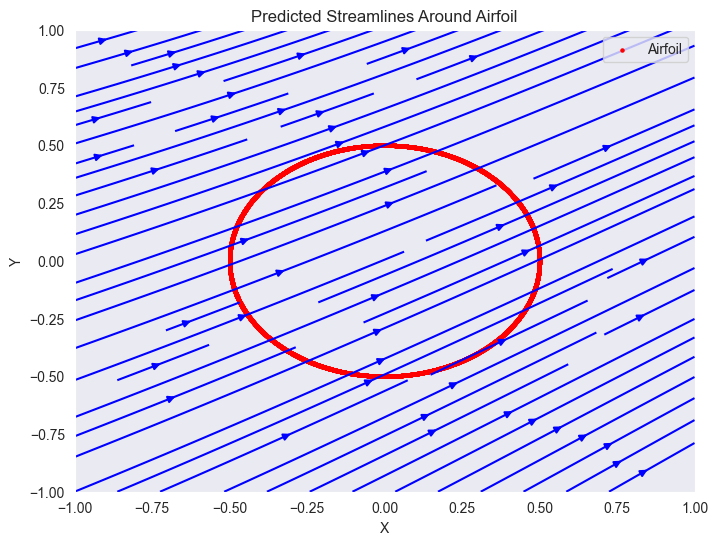

In [8]:
# --- Predict and Visualize Results ---
def visualize_flow(model, X_grid):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_grid, dtype=torch.float32).to(device)
        output = model(X_tensor)
    u, v, p = output[:, 0].cpu().numpy(), output[:, 1].cpu().numpy(), output[:, 2].cpu().numpy()
    return u, v, p

# Generate grid for visualization
x_vis, y_vis = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
X_vis_grid = np.column_stack((x_vis.ravel(), y_vis.ravel()))

u_pred, v_pred, p_pred = visualize_flow(model, X_vis_grid)

# --- Streamline Plot ---
plt.figure(figsize=(8, 6))
plt.streamplot(x_vis, y_vis, u_pred.reshape(100, 100), v_pred.reshape(100, 100), color='blue')
plt.scatter(boundary[:, 0], boundary[:, 1], color='red', s=5, label='Airfoil')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predicted Streamlines Around Airfoil")
plt.legend()
plt.grid()
plt.show()


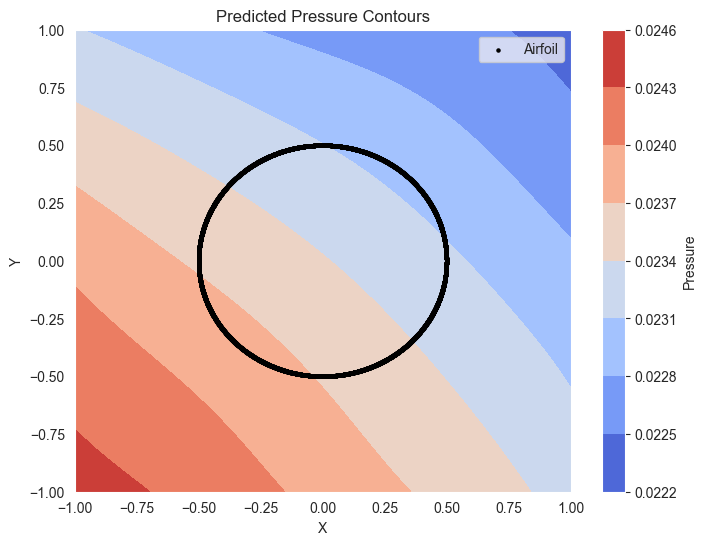

In [9]:
# --- Contour Plot for Pressure ---
plt.figure(figsize=(8, 6))
plt.contourf(x_vis, y_vis, p_pred.reshape(100, 100), cmap='coolwarm')
plt.colorbar(label="Pressure")
plt.scatter(boundary[:, 0], boundary[:, 1], color='black', s=5, label='Airfoil')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predicted Pressure Contours")
plt.legend()
plt.grid()
plt.show()
